In [1]:
%%capture
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!pip install wordcloud
!pip install seaborn
!jupyter nbextension enable --py widgetsnbextension

In [110]:
import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import HTML
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, DistilBertTokenizer, RobertaTokenizer
from transformers import BertPreTrainedModel, BertModel, DistilBertModel, RobertaModel

import pandas as pd
import numpy as np
import re
import os
import wordcloud

from collections import defaultdict
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Full width display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [111]:
def reader(filename, handle_anomalies='drop'):
    """Parses csv file into huggingface-friendly format
    Args:
        filename: name of the csv file
        handle_anomalies: decides how to handle the instances that have 10
                          or 15 grades
    Returns:
        out_dict: dataset as dictionary
        self_df: dataset as dataframe
    """
    # load csv to pandas for easier handling
    self_df = pd.read_csv(filename, dtype={'grades': 'string'})
    # parse and expand grades
    self_df.loc[self_df['grades']=='0', 'grades'] = '00000'
    max_grade_len = self_df['grades'].apply(len).max()
    self_df['grades'] = self_df['grades'].str.replace('', ' ').str.strip()
    grade_names = []
    for i in range(max_grade_len):
        grade_names.append(f'grade {i+1}')
    self_df[grade_names] = self_df['grades'].str.split(' ', expand=True)

    # Turn valid grades to int, missing ones to NaN
    self_df[grade_names] = self_df[grade_names].apply(pd.to_numeric, 
                                                      errors='coerce', 
                                                      downcast='integer')
    # instances with 2 and 3 sets of grades
    two, three = None, None
    if max_grade_len > 5:
        two = self_df['grade 6'].notnull().to_numpy()
        if max_grade_len > 10:
            three = self_df['grade 11'].notnull().to_numpy()

    if handle_anomalies == 'average': # average out the extra grades
        for i in range(1, 6):
            if two:
                values = (self_df.loc[two, f'grade {i}'].to_numpy() + 
                        self_df.loc[two, f'grade {i+5}'].to_numpy()) / 2
                self_df.loc[two, f'grade {i}'] = values
                # slight hack here as it's not a proper average (1/4+1/4+1/2
                # instead of 1/3 each)
            if three:
                values = (self_df.loc[three, f'grade {i}'].to_numpy() + 
                      self_df.loc[three, f'grade {i+10}'].to_numpy()) / 2
                self_df.loc[three, f'grade {i}'] = values

    elif handle_anomalies == 'drop': # simply drop the extra grades, recalculate
                                   # corresponding mean grades
        pass
    for i in range(5, max_grade_len):
        del self_df[f'grade {i+1}']
    del self_df['grades']

    self_df[grade_names[:5]].astype('int32', copy=False)
    # recalibrate the mean grade

    self_df['meanGrade'] = self_df[grade_names[:5]].mean(axis=1).values
    
    # Sanitize using hand-crafted regexes
    self_df = sanitize(self_df)
    out_dict = self_df.to_dict()

    return out_dict, self_df

def sanitize(df):
    """
    Sanitizes the original sentences using hand-crafted rules.
    """
    
    df['original'] = df['original'].str.replace('GOP', 'G.O.P.')
    df['original'] = df['original'].str.replace('US', 'U.S.')
    df['original'] = df['original'].str.replace('Sen\.', 'Senator')

    df['original'] = df['original'].str.replace("'re|’re", 'are')
    df['original'] = df['original'].str.replace("'m|’m", 'am')
    df['original'] = df['original'].str.replace("ca+\s+n’t|ca+\s+n't", 'cannot')
    df['original'] = df['original'].str.replace("n’t|n't", 'not')
    df['original'] = df['original'].str.replace("'ll|’ll", 'will')

    df['original'] = df['original'].str.replace("’+\s|‘+\s", '')
    df['original'] = df['original'].str.replace("'+\s|’+$|'+$", '')
    df['original'] = df['original'].str.replace("“|\"|”", '')
    df['original'] = df['original'].str.replace(",", '')
    df['original'] = df['original'].str.replace(';', ':')

    df['original'] = df['original'].str.replace("@realDonaldTrump", 'Trump')

    outlets = "- BBC News|- BBC New|- Vox| - Los Angeles Times| - CNN Video|\
    - Salon.com|- Breitbart|- The New York Times| - New York Times| - NBC News |\
    - Politics live| -- live stream| -- live updates| - CNNPolitics.com|\
    - Business Insider|- NBC News| - Global Witness"
    df['original'] = df['original'].str.replace(outlets, '')

    return df

class HumicroeditDataset(torch.utils.data.Dataset):
    """Custom dataset class for loading the dataset in a transformer-friendly
    format.
        """
    def __init__(self, tokenizer, input_set, pair=True):
        
        self.tokenizer = tokenizer
        self.pair = pair
        self.ids = input_set['id']
        self.originals = input_set['original']
        self.edits = input_set['edit']
        self.grade_1s = input_set['grade 1']
        self.grade_2s = input_set['grade 2']
        self.grade_3s = input_set['grade 3']
        self.grade_4s = input_set['grade 4']
        self.grade_5s = input_set['grade 5']
        self.mean_grades = input_set['meanGrade']
        self.edited_sentences = defaultdict()
        self.changed_words = defaultdict()

        for id, orig, ed in zip(input_set['id'].values(), input_set['original'].values(), input_set['edit'].values()):
            self.changed_words[id] = re.findall("<(.*)/>", orig)[0]
            self.edited_sentences[id] = re.sub("<.*/>", ed, orig)
    
    def collate_fn(self, batch):
        originals = []
        ids = []
        edits = []
        grades_1 = []
        grades_2 = []
        grades_3 = []
        grades_4 = []
        grades_5 = []
        mean_grades = []
        changed_words = []
        edited = []
        for b in batch:
            ids.append(b['id'])
            originals.append(b['original'])
            edits.append(b['edit'])
            edited.append(self.edited_sentences[b['id']])
            changed_words.append(self.changed_words[b['id']])
            grades_1.append(b['grade 1'])
            grades_2.append(b['grade 2'])
            grades_3.append(b['grade 3'])
            grades_4.append(b['grade 4'])
            grades_5.append(b['grade 5'])
            mean_grades.append(b['mean grade'])

        # The maximum sequence size after tokenization is 74, 
        # so we set the max_length to 160 if pairing sentences and 90 otherwise
        if self.pair:
            encodings = self.tokenizer(originals, edited, return_tensors='pt', 
                                       padding=True, truncation=True, 
                                       max_length=160)
        else:
            encodings = self.tokenizer(edited, return_tensors='pt', 
                                       padding=True, truncation=True, 
                                       max_length=90)
        labels = {}
        encodings['dataset_id'] = torch.tensor(ids)
        encodings['grade 1'] =  torch.tensor(grades_1)
        encodings['grade 2'] =  torch.tensor(grades_2)
        encodings['grade 3'] =  torch.tensor(grades_3)
        encodings['grade 4'] =  torch.tensor(grades_4)
        encodings['grade 5'] =  torch.tensor(grades_5)
        encodings['mean grade'] =  torch.tensor(mean_grades)
        
        return encodings
    
    def __len__(self):
        return len(self.originals)

    def __getitem__(self, idx):
        item = {'id': self.ids[idx],
                'original': self.originals[idx],
                'edit': self.edits[idx],
                'edited': self.edited_sentences[self.ids[idx]],
                'changed word': self.changed_words[self.ids[idx]],
                'grade 1': self.grade_1s[idx],
                'grade 2': self.grade_2s[idx],
                'grade 3': self.grade_3s[idx],
                'grade 4': self.grade_4s[idx],
                'grade 5': self.grade_5s[idx],
                'mean grade': self.mean_grades[idx],
                }
        return item

def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [112]:
model_type = 'roberta'

trainset, train_df = reader('/content/train.csv')
valset, val_df = reader('/content/dev.csv')
testset, test_df = reader('/content/test.csv')
funset, fun_df = reader('/content/train_funlines.csv')

# train+valid set for final training
trainvalset = pd.concat([train_df, val_df]).to_dict()
# training set augmented with funlines
aug_trainset = pd.concat([train_df, fun_df]).to_dict()


if model_type == 'distilbert':
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
elif model_type == 'roberta':
    tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')


train_dataset = HumicroeditDataset(tokenizer, trainset)
val_dataset = HumicroeditDataset(tokenizer, valset)
test_dataset = HumicroeditDataset(tokenizer, testset)
trainval_dataset = HumicroeditDataset(tokenizer, trainvalset)
aug_train_dataset = HumicroeditDataset(tokenizer, aug_trainset)

# Data Exploration

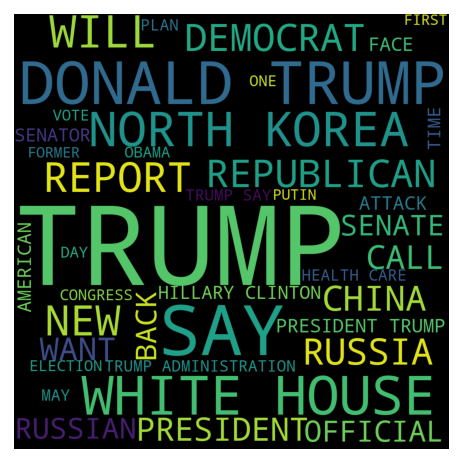

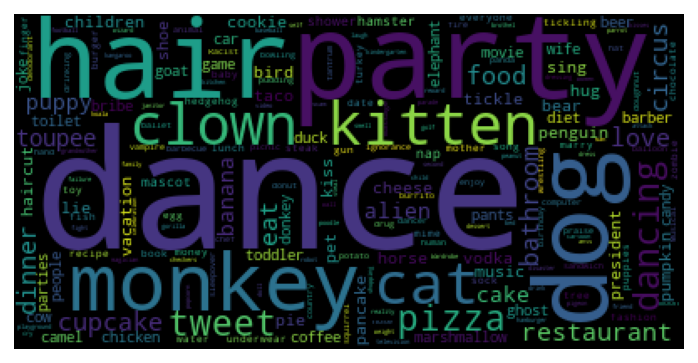

-------------------Funlines------------------- 



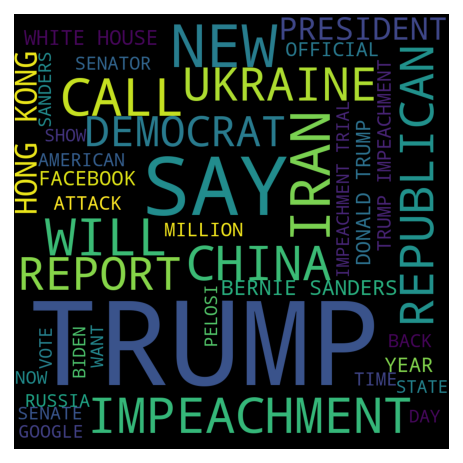

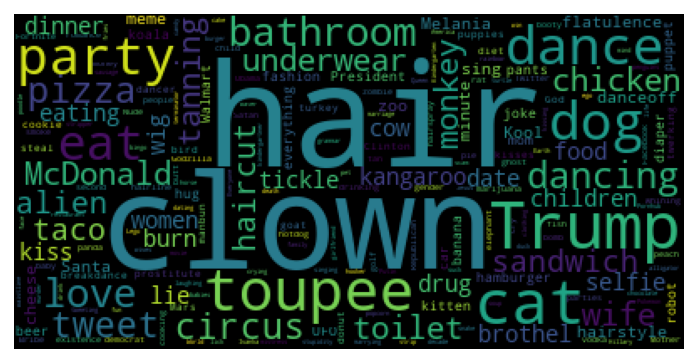

In [113]:
# Run to produce a wordcloud of the original sentences and the edits

text = ' '.join(train_df['original'].values)
wcloud = wordcloud.WordCloud()
wcloud.max_words = 40
wcloud.min_font_size = 6
wcloud.height, wcloud.width = 1000, 1000
wcloud.scale = 1
wcloud.generate(str(text.upper()))

plt.imshow(wcloud)
plt.savefig('wcloud_orig_humicroedit.png')
plt.axis("off")
plt.show()

text = ' '.join(train_df['edit'].values)
wcloud = wordcloud.WordCloud()
wcloud.generate(str(text))
plt.imshow(wcloud)
plt.savefig('wcloud_edits_humicroedit.png')
plt.axis("off")
plt.show()

print(f'-------------------Funlines------------------- \n')

text = ' '.join(fun_df['original'].values)
wcloud = wordcloud.WordCloud()
wcloud.max_words = 40
wcloud.min_font_size = 6
wcloud.height, wcloud.width = 1000, 1000
wcloud.scale = 1
wcloud.generate(str(text.upper()))
plt.imshow(wcloud)
plt.savefig('wcloud_orig_funlines.png')
plt.axis("off")
plt.show()

text = ' '.join(fun_df['edit'].values)
wcloud = wordcloud.WordCloud()
wcloud.generate(str(text))
plt.imshow(wcloud)
plt.savefig('wcloud_edits_funlines.png')
plt.axis("off")
plt.show()

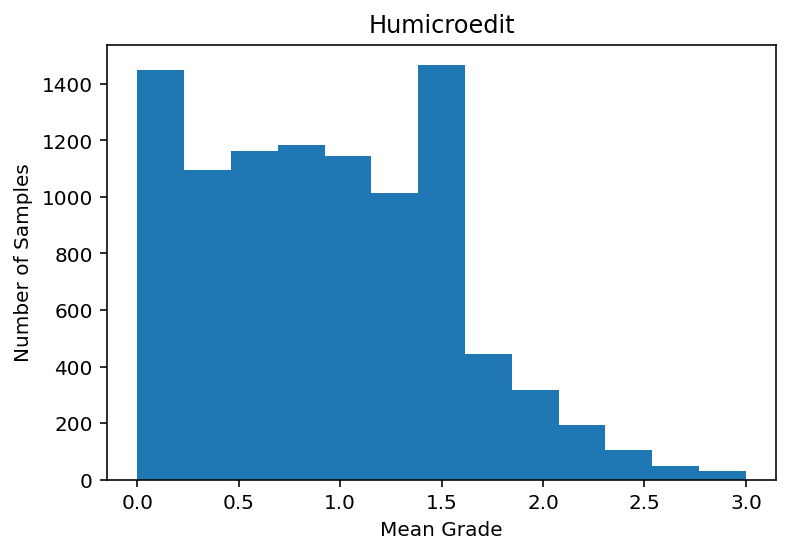

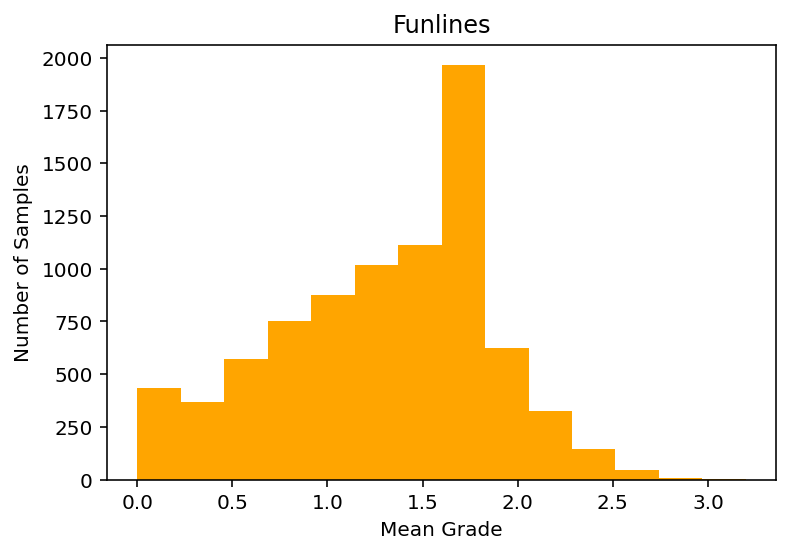

In [114]:
# Plotting the distribution of mean grades in original trainset and funlines
_ = train_df['meanGrade'].hist(grid=False, bins=13) # \m/
plt.xlabel('Mean Grade')
plt.ylabel('Number of Samples')
plt.title('Humicroedit')
plt.savefig('grade_hist_humicroedit.svg')
#Unbalanced dataset
plt.figure()
_ = fun_df['meanGrade'].hist(grid=False, bins=14, color='orange')
plt.xlabel('Mean Grade')
plt.ylabel('Number of Samples')
plt.title('Funlines')
plt.savefig('grade_hist_funlines.svg')

-------------------Humicroedit------------------- 

Training set mean is: 0.946
Training set std is: 0.596
Training set containing Trump mean is: 1.030
-------------------Funlines------------------- 

Training set mean is: 1.283
Training set std is: 0.565
Training set containing Trump mean is: 1.381


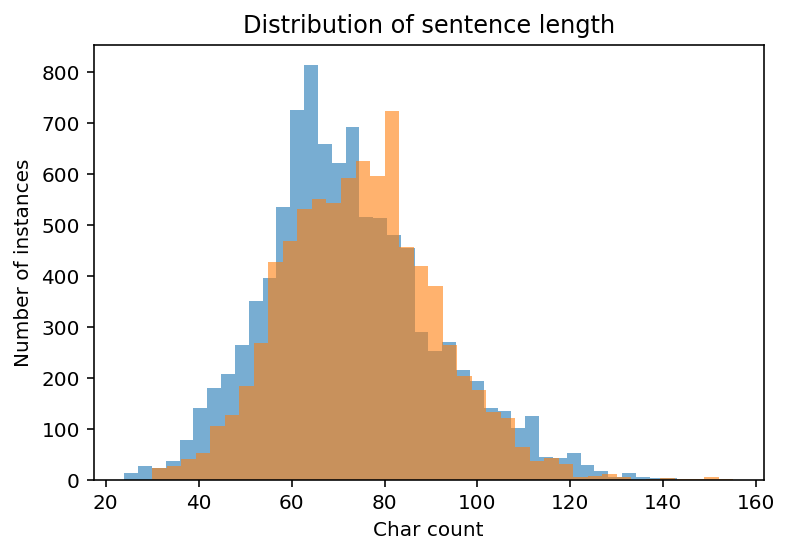

In [115]:
# Quantifying the effect of 'Trump' and plotting the distribution of sentence
# length

print(f'-------------------Humicroedit------------------- \n')
print(f"Training set mean is: {train_df['meanGrade'].mean():.3f}")
print(f"Training set std is: {train_df['meanGrade'].std():.3f}")
print(f"Training set containing Trump mean is: {train_df[train_df['original'].str.contains('Trump')]['meanGrade'].mean():.3f}")

lengths = train_df['original'].apply(len)

_ = lengths.hist(bins=40, grid=False, alpha=0.6)
plt.title('Distribution of sentence length')
plt.xlabel('Char count')
plt.ylabel('Number of instances')
plt.savefig('length_hist_humicroedit.svg')

print(f'-------------------Funlines------------------- \n')

print(f"Training set mean is: {fun_df['meanGrade'].mean():.3f}")
print(f"Training set std is: {fun_df['meanGrade'].std():.3f}")
print(f"Training set containing Trump mean is: {fun_df[fun_df['original'].str.contains('Trump')]['meanGrade'].mean():.3f}")


lengths = fun_df['original'].apply(len)

_ = lengths.hist(bins=40, grid=False, alpha=0.6)
plt.title('Distribution of sentence length')
plt.xlabel('Char count')
plt.ylabel('Number of instances')
plt.savefig('length_hist_funlines.svg')

# Using BERT Embeddings

In [116]:
# Definitions for our 2-styles of models and the evaluation functions

class BERT_regression(nn.Module):
    """
    Simple Regression model using BERT-style models.
    Consists of two linear layers on top of either DistilBERT or RoBERTa,
    followed by dropout.
    """
    def __init__(self, model_type, dropout_p = 0.2):

        super(BERT_regression, self).__init__()
        if model_type == 'distilbert':
            self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
            output_size = 768
        elif model_type == 'roberta':
            self.bert = RobertaModel.from_pretrained("roberta-large-mnli")
            output_size = 1024
        else:
            raise ValueError(f' "{model_type}": Model type not supported')
        
        self.linear = nn.Linear(output_size, output_size)
        self.mean_layer = nn.Linear(output_size, 1)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input_ids=None, attention_mask=None):

        bert_outputs = self.bert(input_ids=input_ids, 
                                 attention_mask=attention_mask)
        
        # get the CLS token embedding
        hiddenstate_output = bert_outputs[0]
        cls_token_output = hiddenstate_output[:, 0]

        output = self.dropout(F.relu(self.linear(cls_token_output)))
        output = self.mean_layer(output)
        #output = self.dropout(output)

        #output = 3 * torch.sigmoid(output)

        return output

class BERT_mean_classification(nn.Module):
    """
    Regression model consisting of BERT-style embeddings followed by a common
    linear layer with a ReLU activation and then 5 different linear layers 
    each of which performs classification on the fields grade 1, grade 2, etc.
    Note how each judge has a separate dropout to promote diversity. 
    """

    def __init__(self, model_type, dropout_p=0.2):

        super().__init__()
        if model_type == 'distilbert':
            self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
            output_size = 768
        elif model_type == 'roberta':
            self.bert = RobertaModel.from_pretrained("roberta-large-mnli")
            output_size = 1024
        else:
            raise ValueError(f' "{model_type}": Model type not supported')

        self.linear = nn.Linear(output_size, output_size)
        self.judge_1 = nn.Linear(output_size, 4)
        self.judge_2 = nn.Linear(output_size, 4)
        self.judge_3 = nn.Linear(output_size, 4)
        self.judge_4 = nn.Linear(output_size, 4)
        self.judge_5 = nn.Linear(output_size, 4)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input_ids=None, attention_mask=None):
 
        bert_outputs = self.bert(input_ids, attention_mask)
        cls_token_output = bert_outputs.last_hidden_state[:, 0]
        common = F.relu(self.linear(cls_token_output))
        out1 = self.judge_1(self.dropout(common))
        out2 = self.judge_2(self.dropout(common))
        out3 = self.judge_3(self.dropout(common))
        out4 = self.judge_4(self.dropout(common))
        out5 = self.judge_5(self.dropout(common))

        return torch.stack((out1, out2, out3, out4, out5))


def eval_reg(loader_val, model):
    """
    Evaluating model performance on the dev set (regression)
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    nb_observations = 0

    with torch.no_grad():
        for batch in loader_val:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['mean grade'].to(device).unsqueeze(1)
            predictions = model(ids, mask)
            loss = nn.MSELoss()(predictions, targets)
            # We get the mse
            pred = predictions.detach().cpu().numpy()
            trg = targets.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)
            epoch_loss += loss.item()*targets.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)
            nb_observations += targets.size(0)

    return (epoch_loss/nb_observations, epoch_sse/nb_observations, 
            np.array(pred_all), np.array(trg_all))


def eval_class(loader_val, model):
    """
    Evaluating model performance on the dev set (mean classification)
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    nb_observations = 0
    with torch.no_grad():
        for batch in loader_val:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['mean grade'].to(device)

            predictions = model(ids, mask) # 5 integer predictions stacked
            pred = torch.Tensor.float(predictions.argmax(axis=-1)).mean(axis=0)
            pred = pred.detach().cpu().numpy()
            trg = targets.detach().cpu().numpy()

            sse, __ = model_performance(pred, trg)
            nb_observations += targets.size(0)
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return (epoch_loss/nb_observations, epoch_sse/nb_observations, 
            np.array(pred_all), np.array(trg_all))


# We define our training loop for the regression model
def train_regression(loader_train, loader_val, model, epochs, ft=False):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    flag `ft` defines if we finetune the transformer weights or freeze them
    """    
    print("Training model.")
    if not ft:
        for param in model.bert.parameters():
            param.requires_grad = False

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0
        epoch_sse = 0
        nb_observations = 0
        nb_tr_steps = 0
        for batch in tqdm(loader_train):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['mean grade'].to(device).unsqueeze(1)
            predictions = model(ids, mask)
            optimizer.zero_grad()
            loss = nn.MSELoss()(predictions, targets)
            loss.backward()
            optimizer.step()
            pred = predictions.detach().cpu().numpy()
            trg = targets.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)
            epoch_loss += loss.item()*targets.shape[0]
            epoch_sse += sse
            nb_tr_steps += 1
            nb_observations += targets.size(0)
        valid_loss, valid_mse, __, __ = eval_reg(loader_val, model)
        epoch_loss, epoch_mse = epoch_loss / nb_observations, epoch_sse / nb_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.3f} |')

# And the mean classification model
def train_mean_classification(loader_train, loader_val, model, epochs, ft=False):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    flag `ft` defines if we finetune the transformer weights or freeze them
    """    
    print("Training model.")
    if not ft:
        for param in model.bert.parameters():
            param.requires_grad = False

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0
        epoch_sse = 0
        nb_observations = 0
        nb_tr_steps = 0

        for batch in tqdm(loader_train):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets_1 = batch['grade 1'].to(device)
            targets_2 = batch['grade 2'].to(device)
            targets_3 = batch['grade 3'].to(device)
            targets_4 = batch['grade 4'].to(device)
            targets_5 = batch['grade 5'].to(device)
            targets = batch['mean grade'].to(device)

            predictions = model(ids, mask) # tuple of the five integer preds
            optimizer.zero_grad()
            loss1 = nn.CrossEntropyLoss()(predictions[0], targets_1)
            loss2 = nn.CrossEntropyLoss()(predictions[1], targets_2)
            loss3 = nn.CrossEntropyLoss()(predictions[2], targets_3)
            loss4 = nn.CrossEntropyLoss()(predictions[3], targets_4)
            loss5 = nn.CrossEntropyLoss()(predictions[4], targets_5)
            loss = (loss1 + loss2 + loss3 + loss4 + loss5 ) / 5
            loss.backward()
            optimizer.step()
            
            pred = torch.Tensor.float(predictions.argmax(axis=-1)).mean(axis=0)
            pred = pred.detach().cpu().numpy()
            trg = targets.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)
            epoch_loss += loss.item()*targets.shape[0]
            epoch_sse += sse
            nb_tr_steps += 1
            nb_observations += targets.size(0)

        valid_loss, valid_mse, __, __ = eval_class(loader_val, model)
        epoch_loss, epoch_mse = epoch_loss / nb_observations, epoch_sse / nb_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.3f} |')

## Simple regression model

In [118]:
# DistilBert settings
if model_type == 'distilbert':
    BATCH_SIZE = 8
    LR = 2e-5
    epochs = 1
    ft = True
# Roberta settings
elif model_type == 'roberta':
    BATCH_SIZE = 8
    LR = 2e-5
    epochs = 2
    ft = True

bert_regression_model = BERT_regression(model_type).to(device)
optimizer = torch.optim.Adam(params=bert_regression_model.parameters(), lr=LR)

loader_train = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=train_dataset.collate_fn,
                                           drop_last=True)
loader_val = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=val_dataset.collate_fn,
                                         drop_last=True,
                                         shuffle=False)

loader_test = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=test_dataset.collate_fn,
                                         shuffle=False)

train_regression(loader_train, loader_val, bert_regression_model, epochs, ft=ft)

Training model.



| Epoch: 01 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.61 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.590 |



| Epoch: 02 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.588 |


In [119]:
# Final training on train+valid
loader_trainval = torch.utils.data.DataLoader(trainval_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=trainval_dataset.collate_fn,
                                         drop_last=True,
                                         shuffle=False)

bert_regression_model = BERT_regression(model_type).to(device)
optimizer = torch.optim.Adam(params=bert_regression_model.parameters(), lr=LR)
train_regression(loader_trainval, loader_val, bert_regression_model, epochs, ft=ft)

Training model.



| Epoch: 01 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.587 |



| Epoch: 02 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.588 |


In [123]:
# Final evaluation on test set after hparam tuning on dev set
# and training on train+val set

_, test_mse, __, __ = eval_reg(loader_test, bert_regression_model)

print(np.sqrt(test_mse))

0.5864000746411243


## Mean Classification model

In [125]:
# DistilBert settings
if model_type == 'distilbert':
    BATCH_SIZE = 8
    LR = 1e-5
    epochs = 2
    ft = True

# Roberta settings
elif model_type == 'roberta':
    BATCH_SIZE = 8
    LR = 2e-5
    epochs = 2
    ft = True

clas_model = BERT_mean_classification(model_type).to(device)
optimizer = torch.optim.Adam(params=clas_model.parameters(), lr=LR)

loader_train = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=train_dataset.collate_fn,
                                           drop_last=True)
loader_val = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=val_dataset.collate_fn,
                                         drop_last=True,
                                         shuffle=False)

loader_test = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=test_dataset.collate_fn,
                                         shuffle=False)

train_mean_classification(loader_train, loader_val, clas_model, epochs,ft=ft)

Training model.



| Epoch: 01 | Train Loss: 1.01 | Train MSE: 0.40 | Train RMSE: 0.63 |         Val. Loss: 0.00 | Val. MSE: 0.35 |  Val. RMSE: 0.590 |



| Epoch: 02 | Train Loss: 1.00 | Train MSE: 0.40 | Train RMSE: 0.63 |         Val. Loss: 0.00 | Val. MSE: 0.37 |  Val. RMSE: 0.604 |


In [126]:
# Final training on train+valid
loader_trainval = torch.utils.data.DataLoader(trainval_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=trainval_dataset.collate_fn,
                                         drop_last=True,
                                         shuffle=True)

clas_model = BERT_mean_classification(model_type).to(device)
optimizer = torch.optim.Adam(params=clas_model.parameters(), lr=LR)
train_mean_classification(loader_trainval, loader_val, clas_model, epochs, ft=ft)

Training model.



| Epoch: 01 | Train Loss: 0.98 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.00 | Val. MSE: 0.26 |  Val. RMSE: 0.510 |



| Epoch: 02 | Train Loss: 0.98 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.00 | Val. MSE: 0.37 |  Val. RMSE: 0.604 |


In [127]:
# Final evaluation on test set after hparam tuning on dev set
# and training on train + valid

_, test_mse, __, __ = eval_class(loader_test, clas_model)

print(np.sqrt(test_mse))

0.6041085161279757


## Using Funlines

In [128]:
BATCH_SIZE = 8
LR = 2e-5
epochs = 3
ft = True
loader_val = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=val_dataset.collate_fn,
                                         drop_last=True,
                                         shuffle=False)
loader_aug = torch.utils.data.DataLoader(aug_train_dataset,
                                         batch_size=BATCH_SIZE,
                                         collate_fn=aug_train_dataset.collate_fn,
                                         drop_last=True,
                                         shuffle=True)

reg_model = BERT_regression(model_type).to(device)
optimizer = torch.optim.Adam(params=reg_model.parameters(), lr=LR)
train_regression(loader_aug, loader_val, reg_model, epochs, ft=ft)

Training model.



| Epoch: 01 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |         Val. Loss: 0.50 | Val. MSE: 0.50 |  Val. RMSE: 0.711 |



| Epoch: 02 | Train Loss: 0.25 | Train MSE: 0.25 | Train RMSE: 0.50 |         Val. Loss: 0.42 | Val. MSE: 0.42 |  Val. RMSE: 0.649 |



| Epoch: 03 | Train Loss: 0.18 | Train MSE: 0.18 | Train RMSE: 0.42 |         Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.607 |


In [129]:
_, test_mse, __, __ = eval_reg(loader_test, reg_model)

print(np.sqrt(test_mse))

0.6118720998705669


# Post-training / Error Analysis

In [ ]:
_, _, pred_all, trg_all = eval_reg(loader_test, bert_regression_model)

In [88]:
def prepare_scatter(trg_all, preds):

    target_space = np.unique(trg_all)
    means = []
    std = []
    for trgt in target_space:
        idx = np.where(trg_all == trgt)[0]
        pr = np.abs(preds[idx] - trg_all[idx])
        means.append(pr.mean())
        std.append(pr.std())
    x = target_space
    y = np.array(means)
    e = np.array(std)

    return x, y, e

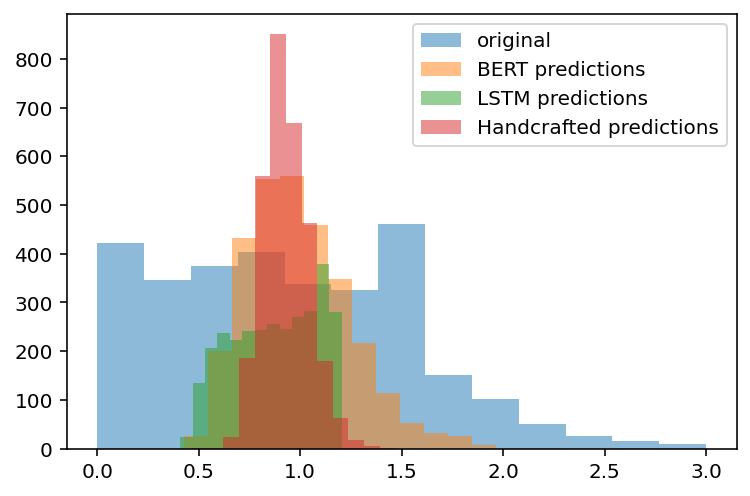

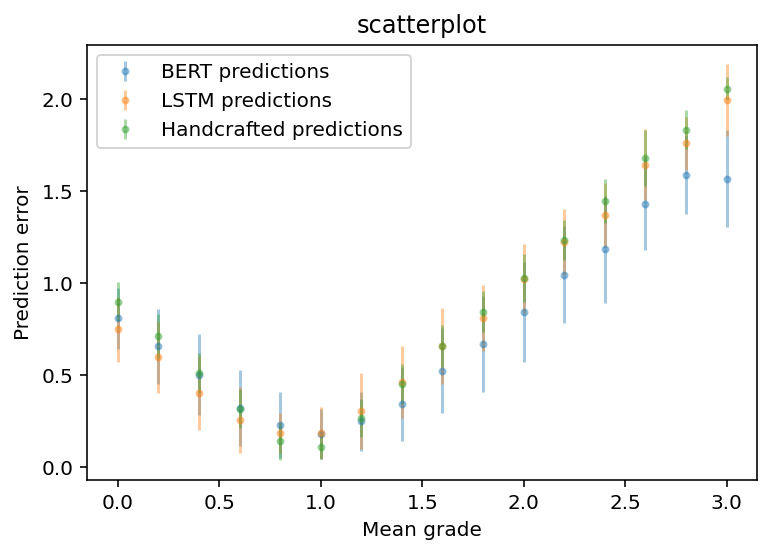

In [90]:
# We perform some error analysis on our predictions
lstm_pred = np.load('lstm_pred.npy')
hc_pred = np.load('test_predictions_hc.npy')
# view model's output distribution of mean grade vs original distr.
_ = plt.hist(trg_all, bins=13, alpha=0.5, label='original')
_ = plt.hist(pred_all, bins=13, alpha=0.5, label='BERT predictions')
_ = plt.hist(lstm_pred, bins=13, alpha=0.5, label='LSTM predictions')
_ = plt.hist(hc_pred, bins=13, alpha=0.5, label='Handcrafted predictions')
plt.legend()
plt.savefig('hist_combined.svg')
# scatterplot between mean grade of input and error or absolute error
plt.figure()
x, y_bert, e_bert = prepare_scatter(trg_all, pred_all)
_, y_lstm, e_lstm = prepare_scatter(trg_all, lstm_pred)
_, y_hc, e_hc = prepare_scatter(trg_all, hc_pred)
_ = plt.errorbar(x, y_bert, e_bert, label='BERT predictions', linestyle='none', marker='.', alpha=0.4)

_ = plt.errorbar(x, y_lstm, e_lstm, label='LSTM predictions', linestyle='none', marker='.', alpha=0.4)
_ = plt.errorbar(x, y_hc, e_hc, label='Handcrafted predictions', linestyle='none', marker='.', alpha=0.4)
plt.xlabel('Mean grade')
plt.ylabel('Prediction error')
plt.title('scatterplot')
plt.legend()
plt.savefig('scatter_combined.svg')

In [45]:
# Top 10 least accurate predictions
residuals = np.abs(pred_all - trg_all).ravel()
worse10 = np.argsort(residuals)[-10:]
print(pred_all[worse10])
test_df.loc[worse10]

[[1.0405178 ]
 [0.83662015]
 [0.8269615 ]
 [1.1911535 ]
 [0.86091113]
 [0.99439687]
 [0.7893314 ]
 [0.96346533]
 [0.6988732 ]
 [0.98183227]]


,id,original,edit,meanGrade,grade 1,grade 2,grade 3,grade 4,grade 5
1368,11076,The Kremlin says Putin and Trump <agreed/> during phone call to step up U.S.-Russian diplomatic efforts on Syria .,rapped,2.6,3,3,3,3,1
1956,14766,NAACP warns African Americans against <travel/> on American Airlines,food,2.4,3,3,3,2,1
2637,8594,Donald Trump <Blasts/> Reporters at Trump Tower For One-Sided Charlottesville Reporting,Moons,2.4,3,3,2,2,2
1833,13723,Chaffetz questions whether Comey <memos/> are actually there,brains,2.8,3,3,3,3,2
2549,4859,4 arrested in Sydney raids to stop terrorist <attack/>,kangaroo,2.6,3,3,3,2,2
852,3409,CNN 's Jake Tapper to <interview/> Paul Ryan following retirement announcement,wrestle,2.8,3,3,3,3,2
2024,588,U.S. drug <companies/> accused of being cheerleaders for opioids,dealers,2.6,3,3,3,2,2
463,11828,In a reversal the Trump administration now says green <card/> holders can enter the U.S.,money,2.8,3,3,3,3,2
1081,13632,Jfk File : Fbi <Monitored/> Martin Luther King 's Abnormal Sex Life of Orgies Hookers and Joan Baez,Enjoyed,2.6,3,3,3,3,1
1345,12561,Scientists appeal for more people to <donate/> their brains,use,3.0,3,3,3,3,3


In [46]:
# Generate new scores for unseen sentences

def score_funniness(tokenizer, model, original, edited, verbose=True):

    encoded = tokenizer(original, edited, return_tensors='pt', padding=True,
                        truncation=True, max_length=160)
    ids = encoded['input_ids'].to(device)
    att = encoded['attention_mask'].to(device)
    model.eval()
    with torch.no_grad():
        out = model(ids, att)
    if verbose:
        print(f'Original: {original} \n'+
            f'Edited: {edited} \n'+
            f'Model\'s prediction: {out.item():.3f}\n')
    
    return out.cpu().numpy()

In [49]:
headline = 'New York prosecutors digging into Trump\'s tax, financial records'
edited = 'New York prosecutors digging into Trump\'s nose, financial records'

_ = score_funniness(tokenizer, bert_regression_model, headline, edited)

Original: New York prosecutors digging into Trump's tax, financial records 
Edited: New York prosecutors digging into Trump's nose, financial records 
Model's prediction: 0.765

